## NIH CheXpert dataset (Classification)

## Import Library

In [1]:
import csv
import numpy as np
from pathlib import Path

# Plot 
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

#import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras import regularizers, optimizers
from keras import backend as K

# model 
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.models import load_model

# metric
from sklearn.metrics import classification_report


Using TensorFlow backend.


## Load data and calculate its counts 

In [2]:
DatasetPath = "D:/Dataset/CheXpert-v1.0-small"
csvPath     = "D:/Dataset/CheXpert-v1.0-small/train.csv"

positive_pos = 15 # 15: Pleural Effusion 
negatvie_pos = 5  # 5: No finding,
third_pos    = 6  # test
data = []
error = 0 
with open(csvPath, newline='') as f:
    rows = csv.reader(f)
    
    row = next(rows)
    title = [row[x] for x in np.asarray([negatvie_pos,positive_pos,third_pos])]

    for line in rows:
        image_name = line[0]
        AP_L       = line[3]
        device       = line[18]

        if(device):
            if(float(device) == 0):
                if(line[positive_pos]):
                    positive_label = float(line[positive_pos])
                    if(positive_label == -1):
                        positive_label = 1
                    positive_label = int(positive_label)
                else:
                    positive_label = 0

                if(line[negatvie_pos]):
                    negative_label = float(line[negatvie_pos])
                    if(negative_label == -1):
                        negative_label = 1
                    negative_label = int(negative_label)
                else:
                    negative_label = 0
                
                if(line[third_pos]):
                    third_label = float(line[third_pos])
                    if(third_label == -1):
                        third_label = 1
                    third_label = int(third_label)
                else:
                    third_label = 0
                if(negative_label == 0 and positive_label == 0 and third_label == 0):
                    continue
                else:
                    labels = []
                    
                    if(negative_label == 1):
                        labels.append(title[0])
                    if(positive_label == 1):
                        labels.append(title[1])
                    if(third_label == 1):
                        labels.append(title[2])
                    data.append((image_name,AP_L,labels))
                #if(positive_label == 1 and negative_label == 0):
                #    data.append((image_name,AP_L,1))
                #elif(positive_label == 0 and negative_label == 1):
                #    data.append((image_name,AP_L,0))
                #else:
                #    continue

data = pd.DataFrame(data, columns=['filename', 'AP_L', 'label'] ,index=None)
data = data[~data[data.columns[1]].str.contains("Lateral")]
print(data['label'].value_counts())
data.head()

[Pleural Effusion]                                2164
[No Finding]                                       553
[Enlarged Cardiomediastinum]                       274
[Pleural Effusion, Enlarged Cardiomediastinum]     240
Name: label, dtype: int64


,filename,AP_L,label
0,CheXpert-v1.0-small/train/patient00019/study4/...,Frontal,[Pleural Effusion]
1,CheXpert-v1.0-small/train/patient00039/study3/...,Frontal,[Enlarged Cardiomediastinum]
2,CheXpert-v1.0-small/train/patient00062/study2/...,Frontal,[Pleural Effusion]
3,CheXpert-v1.0-small/train/patient00084/study2/...,Frontal,[No Finding]
5,CheXpert-v1.0-small/train/patient00128/study12...,Frontal,[Pleural Effusion]


In [12]:
from collections import Counter
labels_count = Counter(label for lbs in data['label'] for label in lbs)
print(labels_count[title[0]])

553


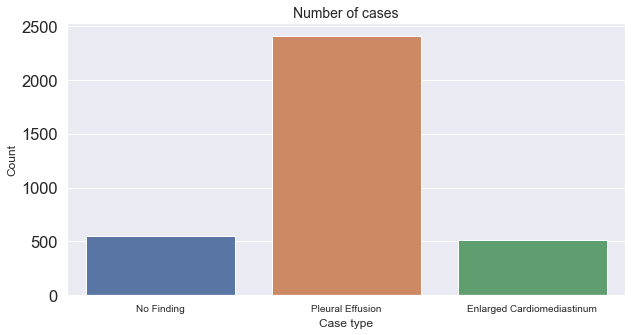

In [29]:
import seaborn as sns
# Get the counts for each class
cases_count = data['label'].value_counts()

# Plot the results 
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5) # for label size
sns.barplot(x = np.linspace(0,len(title)-1,len(title)), y= [labels_count[title[i]] for i in range(len(title))])
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(np.linspace(0,len(title)-1,len(title)), [title[i] for i in range(len(title))], fontsize = 10)
plt.show()


In [36]:
#matplotlib.use("Agg")
from keras.utils import normalize
import cv2 as cv

msk = np.random.rand(len(data)) < 0.8
train_data = data[msk]
val_data = data[~msk]
# data generation for Keras
train_datagen=ImageDataGenerator()#rescale = 1./255,
                                 #featurewise_center=True,
                                 #featurewise_std_normalization=True,
                                 #rotation_range=5,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 #horizontal_flip=True)

target_size = (224,224)

rootPath = "D:/Dataset"
batch = 32
train_generator=train_datagen.flow_from_dataframe(dataframe=train_data, directory=rootPath , x_col="filename", y_col="label", class_mode="categorical", target_size=target_size,  batch_size=batch)
val_generator=train_datagen.flow_from_dataframe(dataframe=val_data, directory=rootPath , x_col="filename", y_col="label", class_mode="categorical", target_size=target_size,  batch_size=batch)



Found 2553 validated image filenames belonging to 3 classes.
Found 678 validated image filenames belonging to 3 classes.


### #model architecture design/selection
# create the base pre-trained model



base_model = DenseNet121(input_shape=(224,224,3),include_top = False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
# add a global spatial average pooling layer

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(16, activation='relu')(x)
# and a logistic layer --  we have 5 classes
predictions = Dense(1, activation='sigmoid')(x)

#print(predictions)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet layers


# compile the model (should be done *after* setting layers to non-trainable)



In [37]:
from keras.layers import Input,Convolution2D,BatchNormalization,Activation,MaxPooling2D
model_input = Input(shape=(224,224,3))
x = Convolution2D(filters = 16, kernel_size = (3,3), strides = 2, padding='same', 
                            data_format = 'channels_last')(model_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides = 2, padding ='same')(x)

x = Convolution2D(filters = 32, kernel_size = (3,3), strides = 1, padding='same', 
                            data_format = 'channels_last')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides = 2, padding ='same')(x)

x = Convolution2D(filters = 64, kernel_size = (3,3), strides = 1, padding='same', 
                            data_format = 'channels_last')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides = 2, padding ='same')(x)

x = Convolution2D(filters = 128, kernel_size = (3,3), strides = 1, padding='same', 
                            data_format = 'channels_last')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides = 2, padding ='same')(x)

x = Convolution2D(filters = 256, kernel_size = (3,3), strides = 1, padding='same', 
                            data_format = 'channels_last')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides = 2, padding ='same')(x)

x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(32, activation='relu')(x)
# and a logistic layer --  we have 5 classes
predictions = Dense(3, activation='sigmoid')(x)

#print(predictions)
model = Model(inputs=model_input, outputs=predictions)
model.summary()
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet layers


# compile the model (should be done *after* setting layers to non-trainable)




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 32)        128 

In [48]:
from sklearn.utils.class_weight import compute_class_weight,compute_sample_weight

#weight = compute_class_weight('balanced', , data['label'].values)
#print(weight)

weight = np.zeros(len(title))
class_sum = 0
for name in title:
    class_sum += labels_count[name]
    weight_idx = train_generator.class_indices[name]
    weight[weight_idx] = 1 / (len(title)*labels_count[name])

weight = weight * class_sum
print(weight)

[2.25097276 2.09222423 0.4812812 ]


In [49]:
# model training
adam = optimizers.Adam(lr=0.0002,decay=0.1)
#SGD  = optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [51]:
# fit model
epochs  = 20
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n / train_generator.batch_size,
                    validation_data=val_generator,
                    validation_steps=val_generator.n / val_generator.batch_size,
                    class_weight = weight,

                    epochs=epochs)


Epoch 1/20
80/79 [==============================] - 9s 107ms/step - loss: 0.4690 - binary_accuracy: 0.8060 - val_loss: 0.6394 - val_binary_accuracy: 0.5708
Epoch 2/20
80/79 [==============================] - 7s 91ms/step - loss: 0.4409 - binary_accuracy: 0.8146 - val_loss: 0.4608 - val_binary_accuracy: 0.7483
Epoch 3/20
80/79 [==============================] - 8s 95ms/step - loss: 0.4339 - binary_accuracy: 0.8192 - val_loss: 0.6647 - val_binary_accuracy: 0.8043
Epoch 4/20
80/79 [==============================] - 7s 94ms/step - loss: 0.4288 - binary_accuracy: 0.8194 - val_loss: 0.8172 - val_binary_accuracy: 0.8038
Epoch 5/20
80/79 [==============================] - 7s 91ms/step - loss: 0.4273 - binary_accuracy: 0.8194 - val_loss: 0.2216 - val_binary_accuracy: 0.8083
Epoch 6/20
80/79 [==============================] - 7s 92ms/step - loss: 0.4250 - binary_accuracy: 0.8180 - val_loss: 0.5822 - val_binary_accuracy: 0.8058
Epoch 7/20
80/79 [==============================] - 7s 92ms/step - lo

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


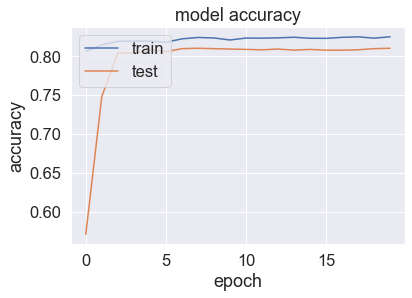

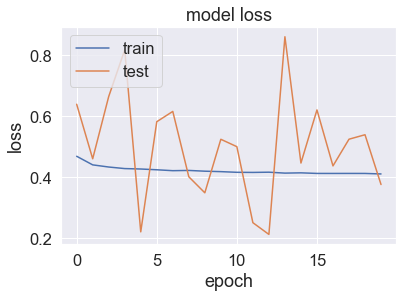

In [52]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()
# summarize history for loss 
plt.figure()
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [55]:
#DatasetPath = "D:/Dataset/CheXpert-v1.0-small"
csvPath     = "D:/Dataset/CheXpert-v1.0-small/valid.csv"

#positive_pos = 15 # 15: Pleural Effusion 
#negatvie_pos = 5  # 5: No finding,
#third_pos    = 6  # test
test_data = []
error = 0 
with open(csvPath, newline='') as f:
    rows = csv.reader(f)
    
    row = next(rows)
    title = [row[x] for x in np.asarray([negatvie_pos,positive_pos,third_pos])]

    for line in rows:
        image_name = line[0]
        AP_L       = line[3]
        device       = line[18]

        if(device):
            if(float(device) == 0):
                if(line[positive_pos]):
                    positive_label = float(line[positive_pos])
                    if(positive_label == -1):
                        positive_label = 1
                    positive_label = int(positive_label)
                else:
                    positive_label = 0

                if(line[negatvie_pos]):
                    negative_label = float(line[negatvie_pos])
                    if(negative_label == -1):
                        negative_label = 1
                    negative_label = int(negative_label)
                else:
                    negative_label = 0
                
                if(line[third_pos]):
                    third_label = float(line[third_pos])
                    if(third_label == -1):
                        third_label = 1
                    third_label = int(third_label)
                else:
                    third_label = 0
                if(negative_label == 0 and positive_label == 0 and third_label == 0):
                    continue
                else:
                    labels = []
                    
                    if(negative_label == 1):
                        labels.append(title[0])
                    if(positive_label == 1):
                        labels.append(title[1])
                    if(third_label == 1):
                        labels.append(title[2])
                    test_data.append((image_name,AP_L,labels))
                #if(positive_label == 1 and negative_label == 0):
                #    data.append((image_name,AP_L,1))
                #elif(positive_label == 0 and negative_label == 1):
                #    data.append((image_name,AP_L,0))
                #else:
                #    continue

test_data = pd.DataFrame(test_data, columns=['filename', 'AP_L', 'label'] ,index=None)
test_data = test_data[~test_data[test_data.columns[1]].str.contains("Lateral")]
print(test_data['label'].value_counts())
test_data.head()

[Enlarged Cardiomediastinum]                      26
[No Finding]                                      26
[Pleural Effusion, Enlarged Cardiomediastinum]    26
[Pleural Effusion]                                 5
Name: label, dtype: int64


,filename,AP_L,label
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Frontal,[Enlarged Cardiomediastinum]
1,CheXpert-v1.0-small/valid/patient64543/study1/...,Frontal,[Enlarged Cardiomediastinum]
2,CheXpert-v1.0-small/valid/patient64544/study1/...,Frontal,[No Finding]
3,CheXpert-v1.0-small/valid/patient64545/study1/...,Frontal,"[Pleural Effusion, Enlarged Cardiomediastinum]"
4,CheXpert-v1.0-small/valid/patient64548/study1/...,Frontal,"[Pleural Effusion, Enlarged Cardiomediastinum]"


In [56]:
#test_datagen=ImageDataGenerator( )#rescale=1./255)
test_generator=train_datagen.flow_from_dataframe(dataframe=test_data, directory=rootPath , x_col="filename", y_col="label", class_mode="categorical", target_size=target_size,  batch_size=1,shuffle = False)

test_generator.reset()
y_pred_keras = model.predict_generator(test_generator,verbose = 1,steps=test_generator.n)

Found 83 validated image filenames belonging to 3 classes.
83/83 [==============================] - 0s 6ms/step


In [69]:
test_generator.class_indices

{'Enlarged Cardiomediastinum': 0, 'No Finding': 1, 'Pleural Effusion': 2}

In [70]:
train_generator.class_indices

{'Enlarged Cardiomediastinum': 0, 'No Finding': 1, 'Pleural Effusion': 2}

In [72]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_labels = mlb.fit_transform(test_generator.labels)

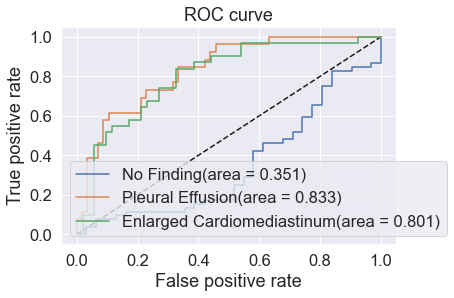

In [73]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

for i in range(len(title)):
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels[:,i], y_pred_keras[:,i])
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, label= title[i] + '(area = {:.3f})'.format(auc_keras))
    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
